In [10]:
from __future__ import print_function
from __future__ import division

import sys
import os
qprc_path = os.path.abspath(os.path.join('..'))
if qprc_path not in sys.path:
    sys.path.append(qprc_path)
    
from utils.plots import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from  kernelfuzzy.fuzzyset import FuzzySet
from kernelfuzzy.fuzzysystem import get_rule_antecedents,plot_membership_fun
from  kernelfuzzy.fuzzification import FuzzyData, NonSingletonFuzzifier
from kernelfuzzy.kernels import gram_matrix_KBF_kernel,KBFkernel,NonSingletonKernel
from sklearn.datasets.samples_generator import make_classification
from sklearn.datasets import make_moons, make_circles,make_blobs,load_digits
from sklearn.svm import SVC,NuSVC
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from kernelfuzzy.kernels import nonsingleton_gaussian_kernel, gram_matrix_nonsingleton_gaussian_kernel
from sklearn.metrics import accuracy_score
import skfuzzy as fuzz # for FCM
import pickle

This notebook compares a data-driven  construction of Membership functions (MFs) by 1) Linguistic Modified Fuzzy C-Means clustering (LMFCM) vs 2) regularized kernel machines
* LMFCM paper: Fuzzy Set Qualitative Comparative Analysis(fsQCA): Challenges and Applications

## MPG dataset


In [2]:
#MPG data
file1 = 'https://raw.githubusercontent.com/prince381/car_mpg_predict/master/cars1.csv'
file2 = 'https://raw.githubusercontent.com/prince381/car_mpg_predict/master/cars2.csv'

cars1 = pd.read_csv(file1)   # read in the first data file
cars2 = pd.read_csv(file2)   # read in the second data file

# we have other columns named unamed which contains only NaN values
# so we drop them.
cars1.drop(cars1.columns[9:],axis=1,inplace=True) 

# concatenate the two data
cars = pd.concat([cars1,cars2])
cars.head()  # print the first five rows of the data

# replace '?' with NaN values representing a missing data.
cars.horsepower = cars.horsepower.str.replace('?','NaN').astype(float)
# fill the missing data with the mean value of horsepower
cars.horsepower.fillna(cars.horsepower.mean(),inplace=True)
# change the data type to integer
cars.horsepower = cars.horsepower.astype(int)

# print the info of the data again to see the datatypes of columns
cars.info()
# won't be needing the car column so we drop it
cars = cars.drop(['car','cylinders','acceleration','model','origin'],axis=1)
cars.head()  # print the first five rows of the data


<class 'pandas.core.frame.DataFrame'>
Int64Index: 398 entries, 0 to 199
Data columns (total 9 columns):
mpg             398 non-null float64
cylinders       398 non-null int64
displacement    398 non-null int64
horsepower      398 non-null int64
weight          398 non-null int64
acceleration    398 non-null float64
model           398 non-null int64
origin          398 non-null int64
car             398 non-null object
dtypes: float64(2), int64(6), object(1)
memory usage: 31.1+ KB


,mpg,displacement,horsepower,weight
0,18.0,307,130,3504
1,15.0,350,165,3693
2,18.0,318,150,3436
3,16.0,304,150,3433
4,17.0,302,140,3449


## Membership functions from  LMFCM

Colunm Name :  displacement


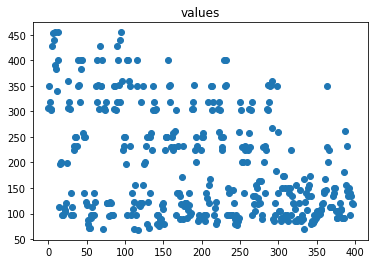

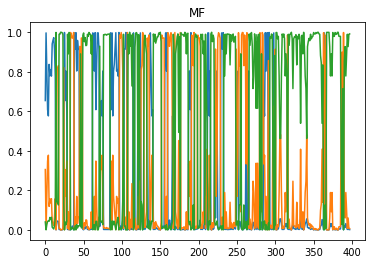

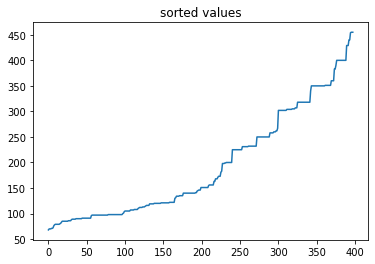

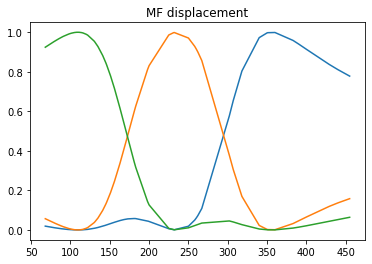

Colunm Name :  horsepower


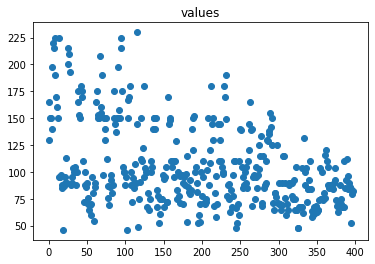

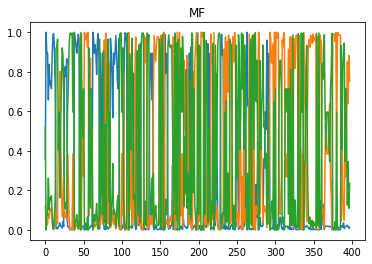

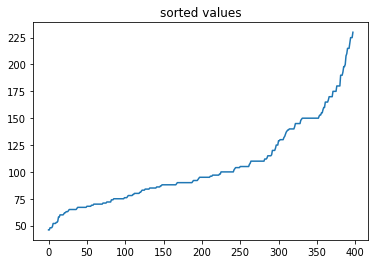

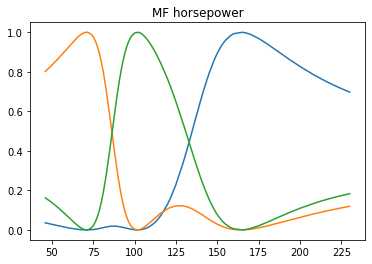

Colunm Name :  weight


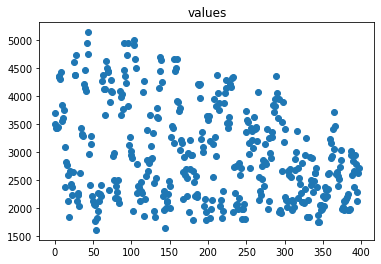

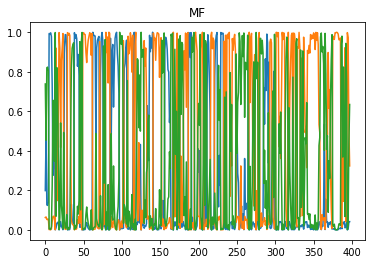

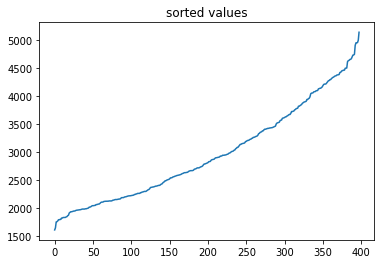

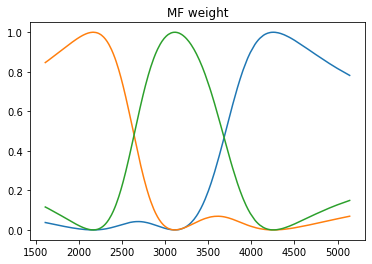

Colunm Name :  displacement


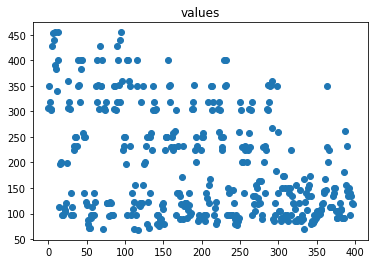

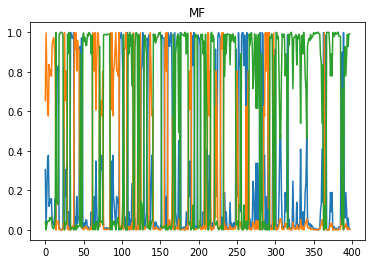

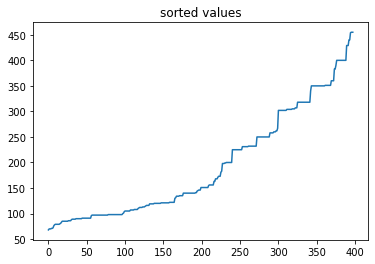

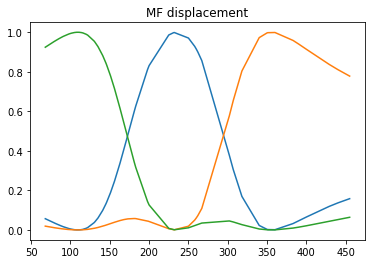

Colunm Name :  horsepower


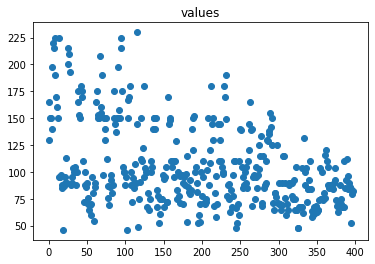

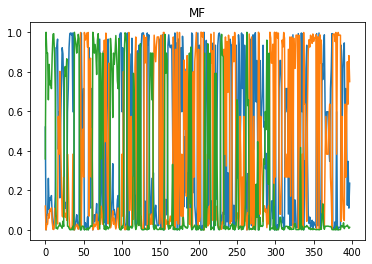

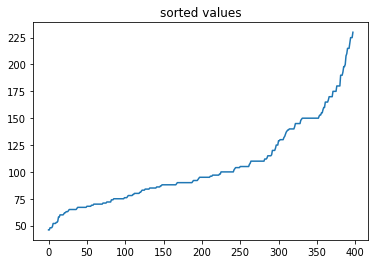

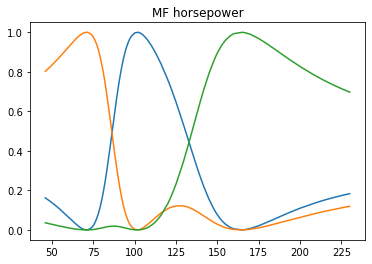

Colunm Name :  weight


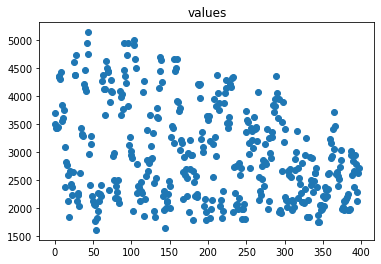

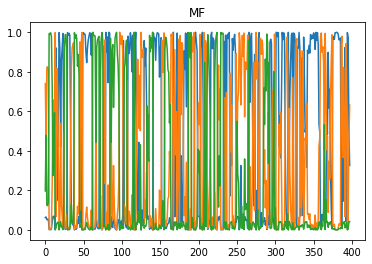

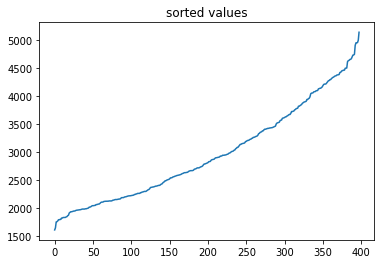

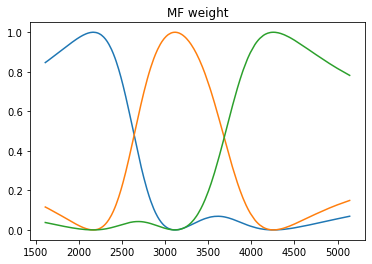

In [15]:
#cluster each variable independently
colnames=['displacement','horsepower','weight']
n_centers_per_column=[3,3,3]
df=cars

plot_mf_FCM(df, colnames, n_centers_per_column)

## Membership functions from SVM with nonsingleton kernel on fuzzy sets

In [4]:
from sklearn.svm import NuSVR
X = cars.drop('mpg',axis=1).to_numpy()
# create a series of the dependent variable
y = cars.mpg.to_numpy()   

pipe = Pipeline([
    ('Fuzzifier', NonSingletonFuzzifier(constant_std=True)),
    ('NSKernel', NonSingletonKernel()),
    ('svm', NuSVR())])

#grid search over KBF kernel parameter   
cv_params = dict([
    ('Fuzzifier__std_proportion',np.arange(0.01,np.std(X),0.1)),
    ('NSKernel__param', 2.0**np.arange(-20,20)),
    ('svm__kernel', ['precomputed']),
    ('svm__nu', np.arange(0.05,0.1,0.05)),
])

#model = GridSearchCV(pipe, cv_params, cv=5, verbose=1, n_jobs=-1)
model_SVM_NS = RandomizedSearchCV(pipe, cv_params, cv=5, verbose=1, n_jobs=-1,n_iter=100)
model_SVM_NS.fit(X, y)
    
print('Model parameters : {}'.format(model_SVM_NS.best_params_))
print('support vectors: {}'.format( model_SVM_NS.best_estimator_['svm'].support_))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 11.6min finished
//anaconda/envs/fuzzy-kernels/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



Model parameters : {'svm__nu': 0.05, 'svm__kernel': 'precomputed', 'NSKernel__param': 0.03125, 'Fuzzifier__std_proportion': 64.31}
support vectors: [ 13  25  26  27  28  71 103 111 112 124 166 244 309 322 325 326 327 329
 330 387 394]


Membership function Rule antecedents


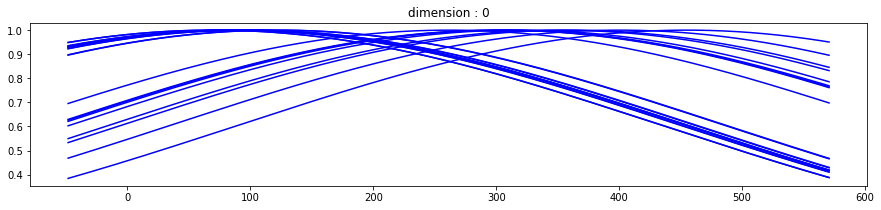

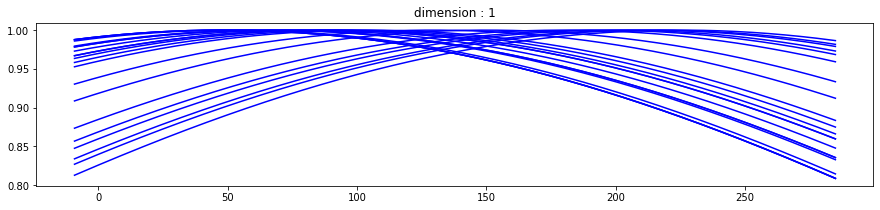

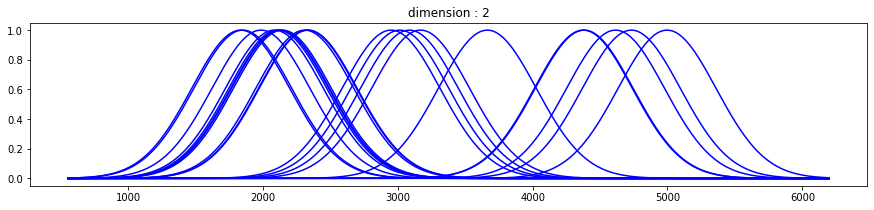

Membership function of fuzzy numbers linked to rule antecedents


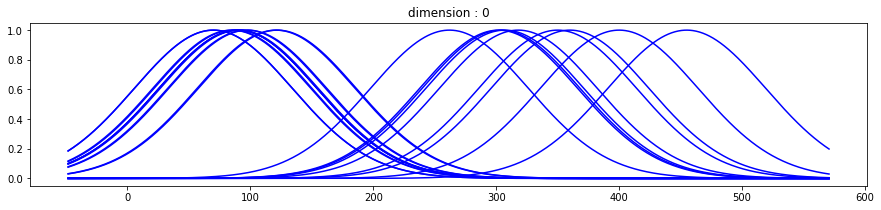

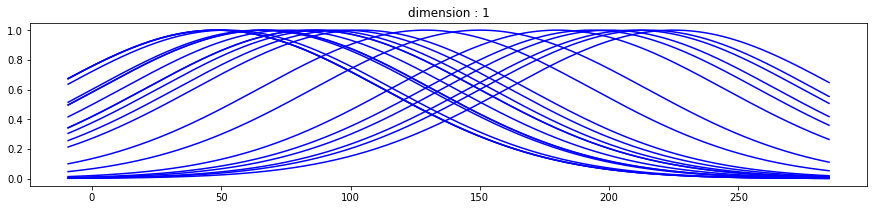

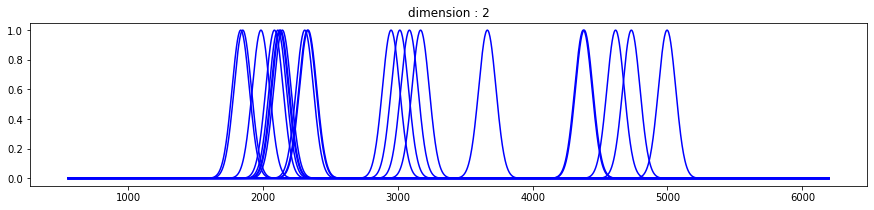

plot of vectors of fuzzy sets linked to rule antecedents


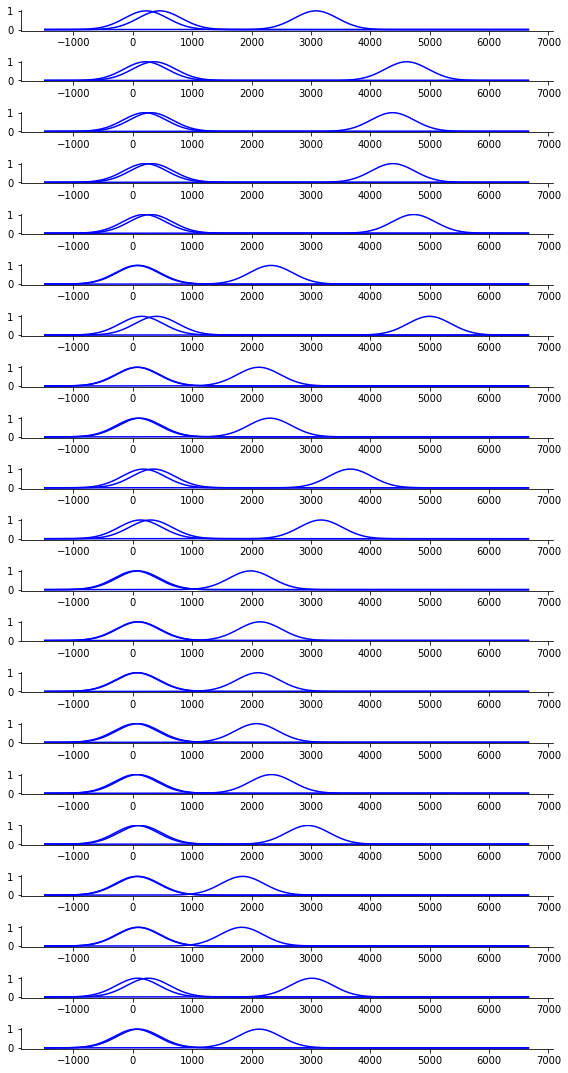

plot of vectors of fuzzy sets linked to the fuzzy numbers linked to rule antecedents


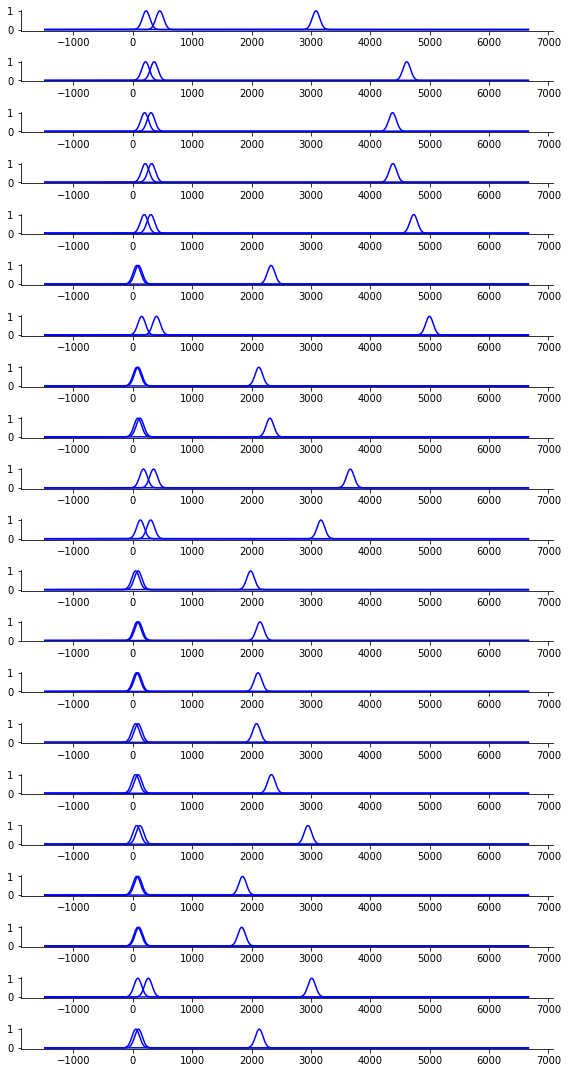

In [14]:
#rule generation
percentage_x_plot=30
gamma=model_SVM_NS.best_params_['NSKernel__param']
std_proportion=model_SVM_NS.best_params_['Fuzzifier__std_proportion']
fuzzy_data=NonSingletonFuzzifier( std_proportion=std_proportion, constant_std=True ).transform(X,y)

rules_antecedents=get_rule_antecedents(model_SVM_NS.best_estimator_['svm'], fuzzy_data, gamma)
print("Membership function Rule antecedents")
plot_membership_fun(rules_antecedents,X,percentage_x_plot)
print("Membership function of fuzzy numbers linked to rule antecedents")
plot_membership_fun(fuzzy_data[model_SVM_NS.best_estimator_['svm'].support_,:],X,percentage_x_plot)

print("plot of vectors of fuzzy sets linked to rule antecedents")
plot_fuzzydata(rules_antecedents,X,percentage_x_plot)
print("plot of vectors of fuzzy sets linked to the fuzzy numbers linked to rule antecedents")
plot_fuzzydata(fuzzy_data[model_SVM_NS.best_estimator_['svm'].support_,:],X,percentage_x_plot)


Colunm Name :  displacement


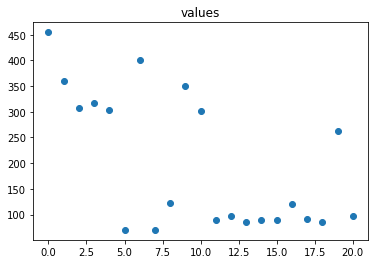

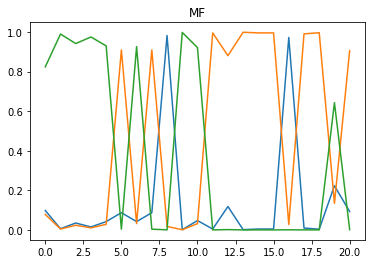

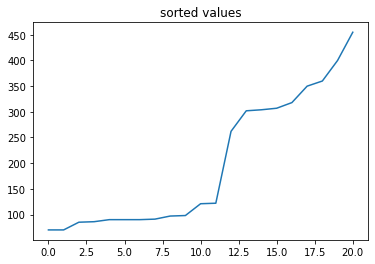

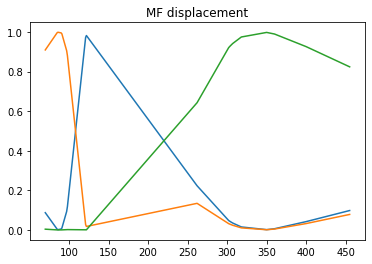

Colunm Name :  horsepower


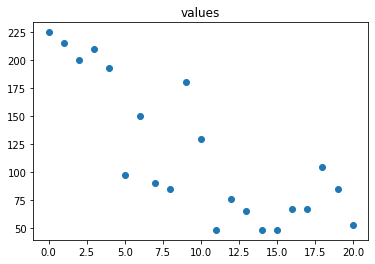

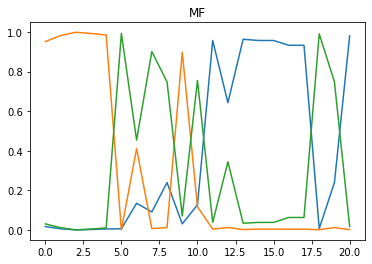

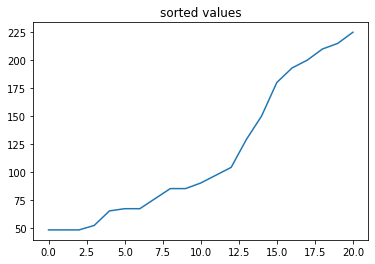

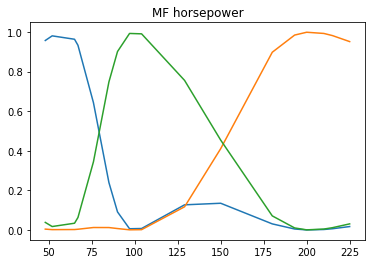

Colunm Name :  weight


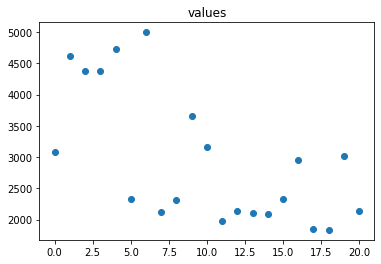

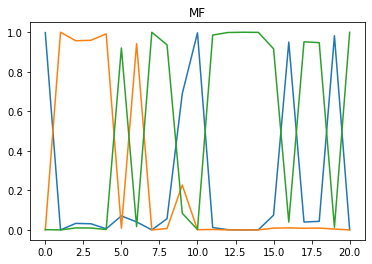

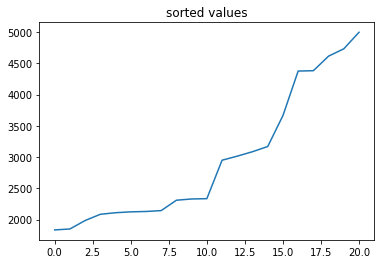

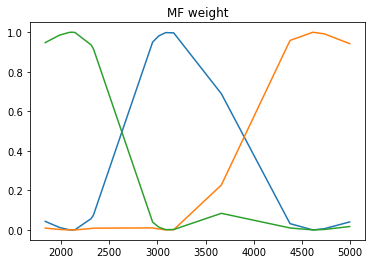

In [19]:
#clustering the fuzzy numbers
colnames=['displacement','horsepower','weight']
n_centers_per_column=[3,3,3]
plot_mf_FCM(cars.iloc[model_SVM_NS.best_estimator_['svm'].support_], colnames, n_centers_per_column)

In [7]:
# using KBF kernel
pipe = Pipeline([
    ('Fuzzifier', NonSingletonFuzzifier(constant_std=True)),
    ('Kernel', KBFkernel()),
    ('svm', NuSVR())])

#grid search over KBF kernel parameter   
cv_params = dict([
    ('Fuzzifier__std_proportion',np.arange(0.01,np.std(X),0.1)),
    ('Kernel__param', 2.0**np.arange(-5,-3)),
    ('svm__kernel', ['precomputed']),
    ('svm__nu', np.arange(0.05,0.1,0.05)),
])

#model = GridSearchCV(pipe, cv_params, cv=5, verbose=1, n_jobs=-1)
model_SVM_KBF = RandomizedSearchCV(pipe, cv_params, cv=5, verbose=1, n_jobs=-1,n_iter=100)
model_SVM_KBF.fit(X, y)

print('Model parameters : {}'.format(model_SVM_KBF.best_params_))
print('support vectors: {}'.format( model_SVM_KBF.best_estimator_['svm'].support_))


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 12.4min finished
//anaconda/envs/fuzzy-kernels/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



Model parameters : {'svm__nu': 0.05, 'svm__kernel': 'precomputed', 'Kernel__param': 0.0625, 'Fuzzifier__std_proportion': 7.61}
support vectors: [ 25  26  27  28  67  69  95 103 104 106 124 244 247 309 322 324 325 326
 329 330 394]


Membership function Rule antecedents


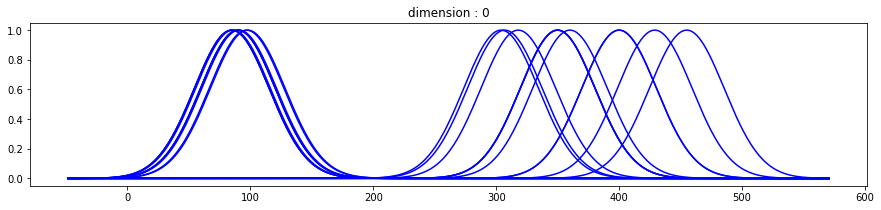

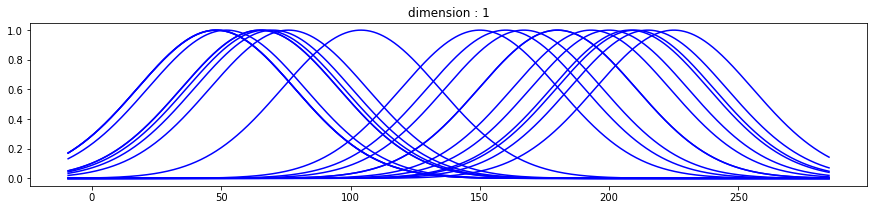

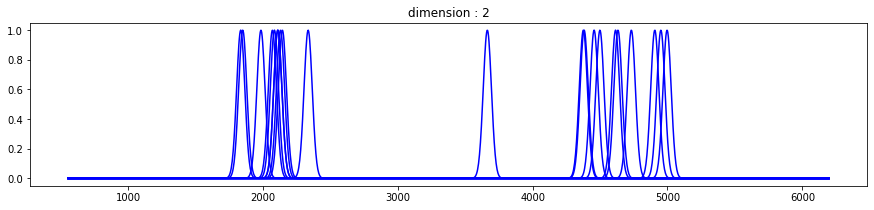

Membership function of fuzzy numbers linked to rule antecedents


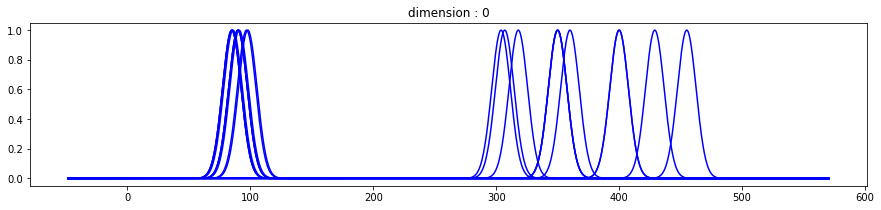

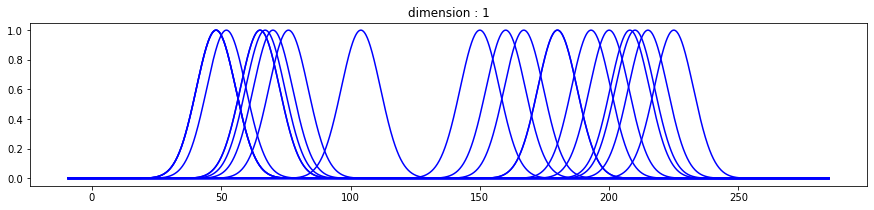

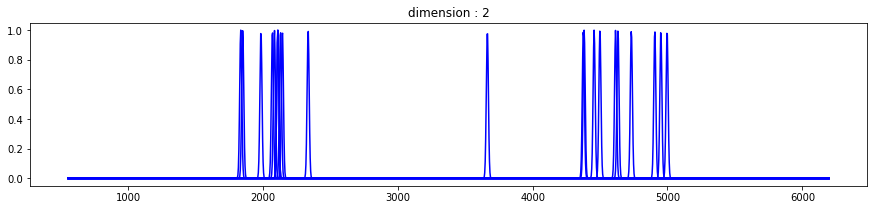

plot of vectors of fuzzy sets linked to rule antecedents


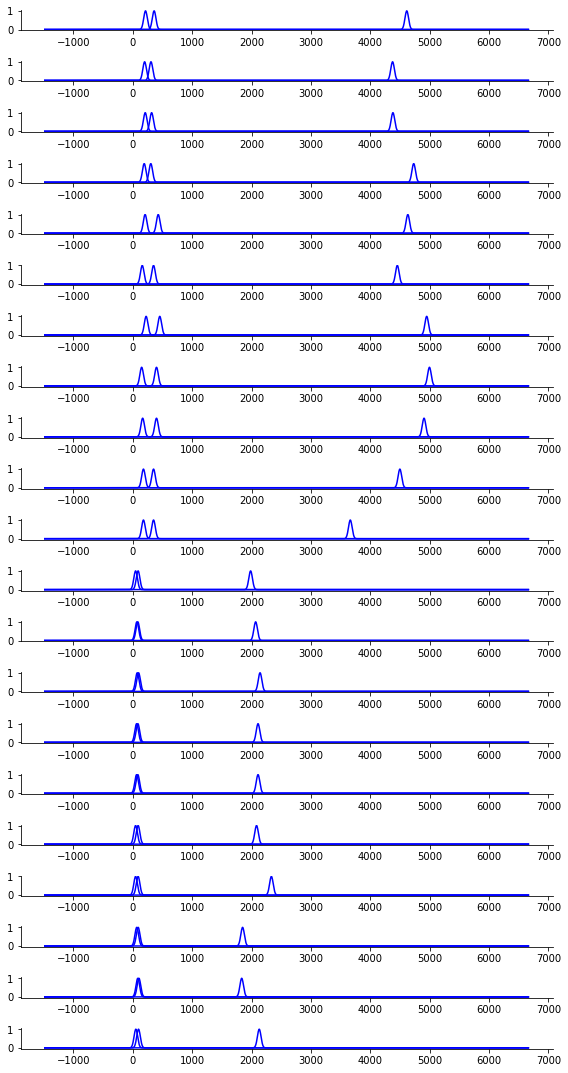

plot of vectors of fuzzy sets linked to the fuzzy numbers linked to rule antecedents


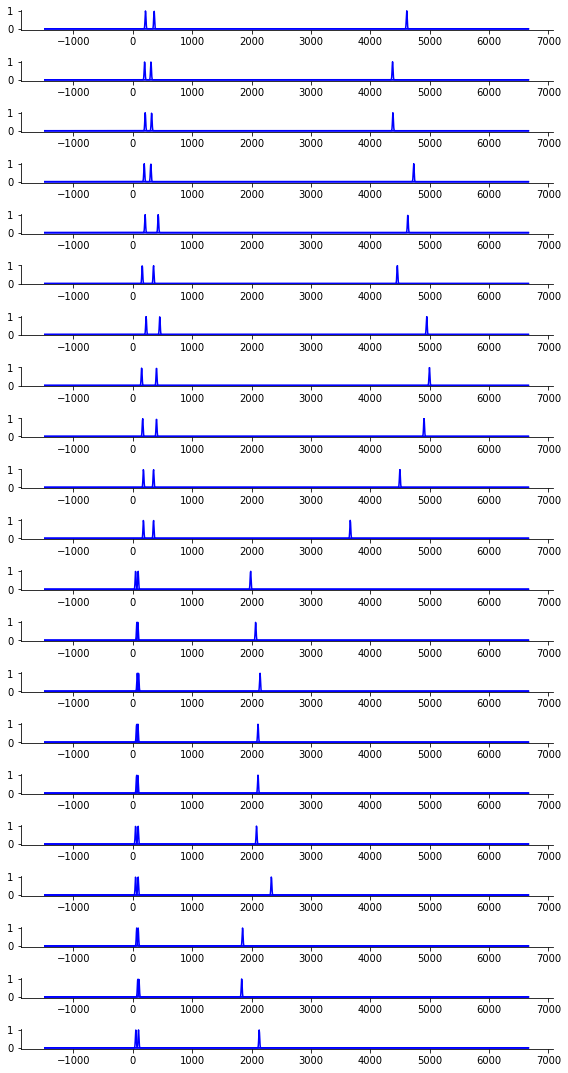

In [9]:
percentage_x_plot=30
gamma=model_SVM_KBF.best_params_['Kernel__param']
std_proportion=model_SVM_KBF.best_params_['Fuzzifier__std_proportion']
fuzzy_data=NonSingletonFuzzifier( std_proportion=std_proportion, constant_std=True ).transform(X,y)
rules_antecedents=get_rule_antecedents(model_SVM_KBF.best_estimator_['svm'], fuzzy_data, gamma)
print("Membership function Rule antecedents")
plot_membership_fun(rules_antecedents,X,percentage_x_plot)
print("Membership function of fuzzy numbers linked to rule antecedents")
plot_membership_fun(fuzzy_data[model_SVM_KBF.best_estimator_['svm'].support_,:],X,percentage_x_plot)

print("plot of vectors of fuzzy sets linked to rule antecedents")
plot_fuzzydata(rules_antecedents,X,percentage_x_plot)
print("plot of vectors of fuzzy sets linked to the fuzzy numbers linked to rule antecedents")
plot_fuzzydata(fuzzy_data[model_SVM_KBF.best_estimator_['svm'].support_,:],X,percentage_x_plot)

Colunm Name :  displacement


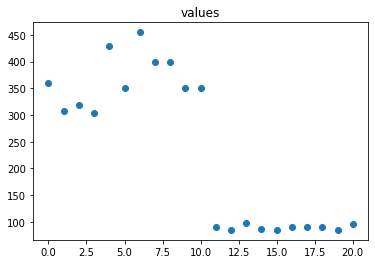

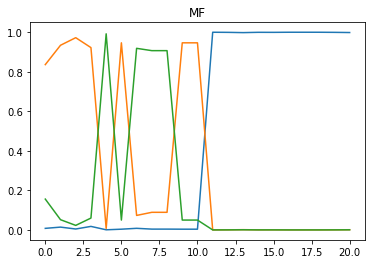

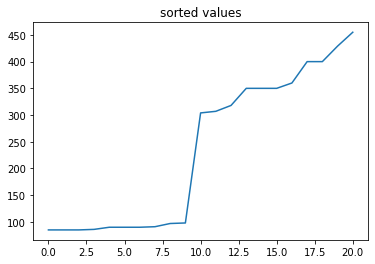

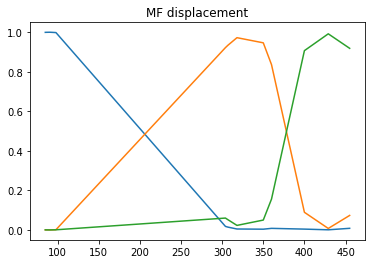

Colunm Name :  horsepower


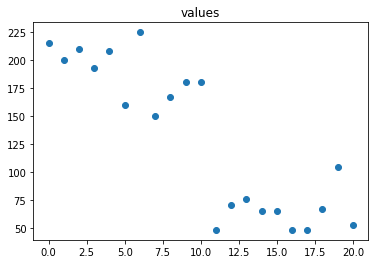

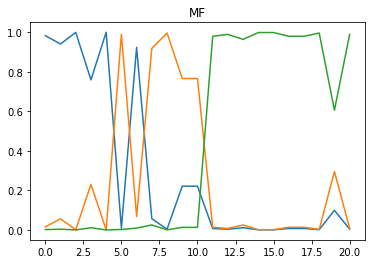

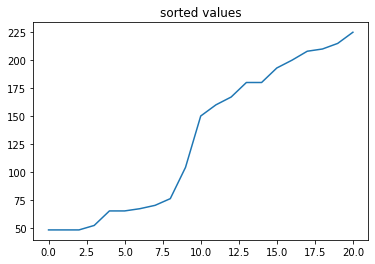

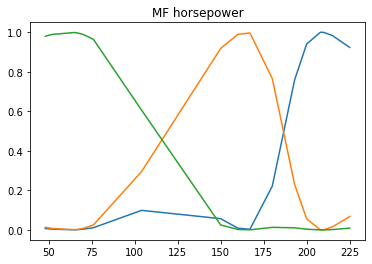

Colunm Name :  weight


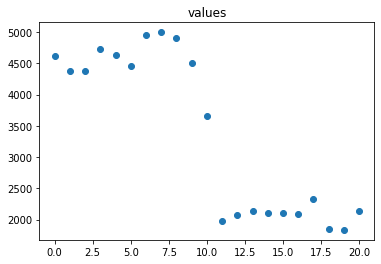

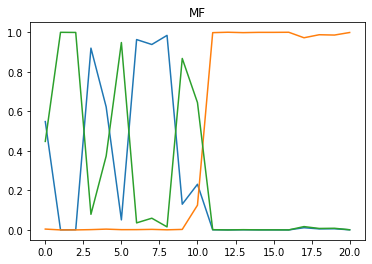

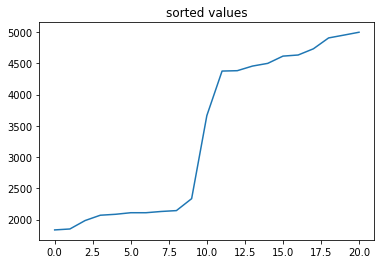

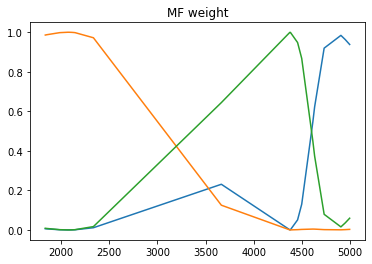

In [20]:
#clustering the fuzzy numbers
colnames=['displacement','horsepower','weight']
n_centers_per_column=[3,3,3]
plot_mf_FCM(cars.iloc[model_SVM_KBF.best_estimator_['svm'].support_], colnames, n_centers_per_column)

In [12]:
# saving
file = 'svmNS.pkl'
with open(file, 'wb') as f:
    pickle.dump(model_SVM_NS, f, pickle.HIGHEST_PROTOCOL)
            
# saving
file = 'svmKBF.pkl'
with open(file, 'wb') as f:
    pickle.dump(model_SVM_KBF, f, pickle.HIGHEST_PROTOCOL)
